Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


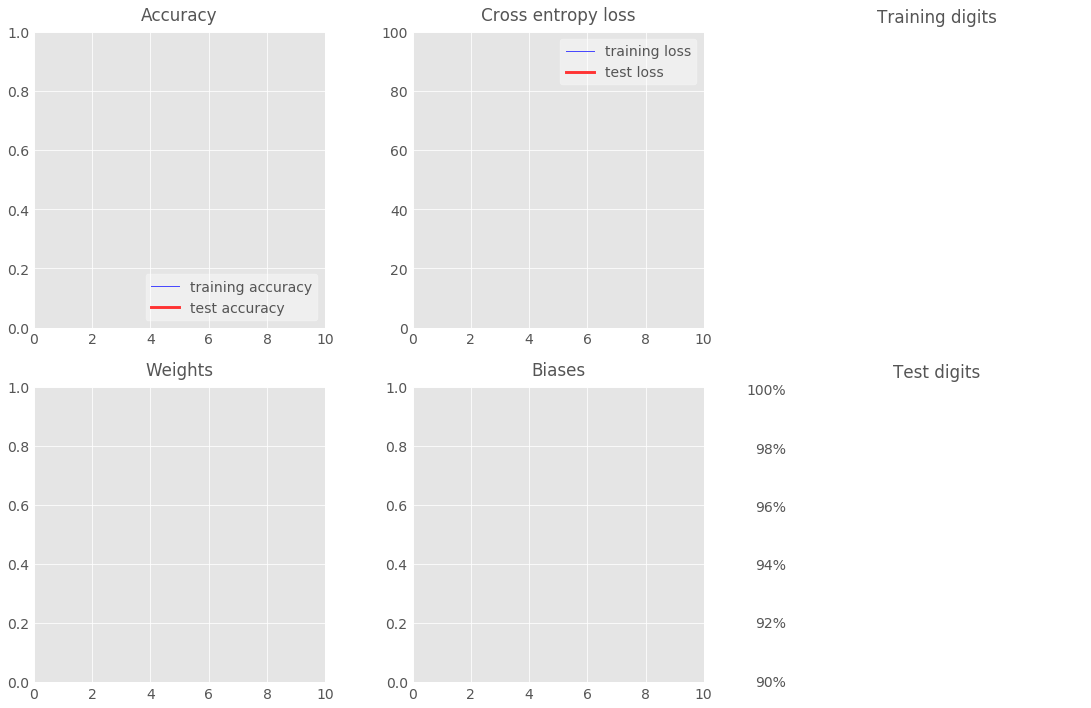

test accuracy: 0


In [1]:
#tensorflow demo Digit recognition

import tensorflow as tf
import tensorflowvisu
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
tf.set_random_seed(0)

# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

#placeholder for training set
X = tf.placeholder(tf.float32, [None, 28, 28, 1])

#variables to be determined
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

init = tf.global_variables_initializer()


#model
Y = tf.nn.softmax(tf.matmul(tf.reshape(X,[-1, 784]), W) + b)
#placeholder for correct labels
Y_ = tf.placeholder(tf.float32, [None, 10])

#loss function that needs to be minimized
cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y))*1000.0

# % of correct answers found in batch
is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

#optimizer
optimizer = tf.train.GradientDescentOptimizer(0.003)
train_step = optimizer.minimize(cross_entropy)


# matplotlib visualisation
allweights = tf.reshape(W, [-1])
allbiases = tf.reshape(b, [-1])
I = tensorflowvisu.tf_format_mnist_images(X, Y, Y_)  # assembles 10x10 images by default
It = tensorflowvisu.tf_format_mnist_images(X, Y, Y_, 1000, lines=25)  # 1000 images on 25 lines
datavis = tensorflowvisu.MnistDataVis()


#training
sess = tf.Session()
sess.run(init)

# for i in range(1000):
# 	#load training images and their correct labels
# 	batch_X, batch_Y = mnist.train.next_batch(100)
# 	train_data = {X: batch_X, Y_: batch_Y}

# 	#train
# 	sess.run(train_step, feed_dict = train_data)


# # success ?
# a,c = sess.run([accuracy, cross_entropy], feed_dict=train_data)

# # check on test data
# test_data={X: mnist.test.images, Y_: mnist.test.labels}
# a,c = sess.run([accuracy, cross_entropy], feed=test_data)

# You can call this function in a loop to train the model, 100 images at a time
def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    # compute training values for visualisation
    if update_train_data:
        a, c, im, w, b = sess.run([accuracy, cross_entropy, I, allweights, allbiases], feed_dict={X: batch_X, Y_: batch_Y})
        datavis.append_training_curves_data(i, a, c)
        datavis.append_data_histograms(i, w, b)
        datavis.update_image1(im)
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))

    # compute test values for visualisation
    if update_test_data:
        a, c, im = sess.run([accuracy, cross_entropy, It], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        datavis.append_test_curves_data(i, a, c)
        datavis.update_image2(im)
        print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})

#animation
datavis.animate(training_step, iterations=2000+1, train_data_update_freq=10, test_data_update_freq=50, more_tests_at_start=True)

print("test accuracy: " + str(datavis.get_max_test_accuracy()))

